In [47]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
from torchvision import datasets, transforms, models, utils
import torch.nn.functional as F
from torch.autograd import Variable
import time
from glob import glob
from torch.utils.data.sampler import SubsetRandomSampler
from collections import OrderedDict
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import sys
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(device)
sys.path.append("../")
from src.datasplit import DataSplit

cpu


In [49]:
# Set up Variable
data_path = "../data/"
raw_data_path = data_path + "raw/"
intermediate_data_path = data_path + "interim/"
full_annotation_name = intermediate_data_path + "full_annotation.csv"

In [50]:
annotation_df = pd.read_csv(raw_data_path+'annotation.csv')
annotation_df.head()
print("Annotation data: ",len(annotation_df))

Annotation data:  1026


In [51]:
all_files = glob(raw_data_path+"images/*")
all_jpgs = sorted([img for img in all_files if ".jpg" in img or ".jpeg" in img or "JPG" in img])
print("Total {} photos ".format(len(all_jpgs)))

Total 1026 photos 


In [52]:
id_path = [image for image in all_jpgs ]
image_df = pd.DataFrame(id_path, columns=['path'])

In [53]:
full_df = image_df.merge(annotation_df, left_index=True, right_index=True)
full_df = full_df.drop(['image'], axis=1)
full_df.to_csv(full_annotation_name, index=False, header=True)
full_df.head()

,path,height,weight,BMI
0,../data/raw/images/f_001.jpg,1.55,61.0,25.390219
1,../data/raw/images/f_002.jpg,1.76,85.0,27.440599
2,../data/raw/images/f_003.jpg,1.78,56.0,17.674536
3,../data/raw/images/f_004.jpg,1.63,63.0,23.711845
4,../data/raw/images/f_005.jpg,1.76,54.0,17.432851


Image path: ../data/raw/images/f_066.jpg
Values shape: (1, 3)
height: 1.77 m, weight: 55.0 kg, bmi: 17.55561939


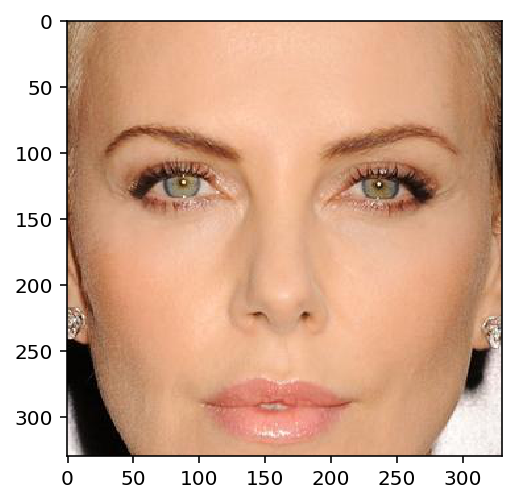

In [54]:
import matplotlib.image as mpimg
#Get a sample entry
n = 65
image_path = full_df.iloc[n, 0]
values = np.asarray(full_df.iloc[n, 1:])
values = values.astype('float').reshape(-1, 3)

print('Image path: {}'.format(image_path))
print('Values shape: {}'.format(values.shape))
print('height: {} m, weight: {} kg, bmi: {}'.format(*values[:, 0], *values[:, 1], *values[:, 2]))

image = mpimg.imread(image_path)
plt.imshow(image);

In [55]:
#Define 2 transformation for train data and test data
data_transforms = {
    "default": transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor()
    ]),
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
        ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    'test': transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.ToTensor()
        ]),
}

In [56]:
#Data loader class
class FaceToBMIDataset(Dataset):
    def __init__(self, csv_file, image_dir):
        self.annotaion = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.set_transform()

    def __len__(self):
        return len(self.annotaion)

    def set_transform(self, type=None):
        if type == "train":
            print('Using train transformation')
            self.transform = data_transforms['train']
        elif type == "val":
            print('Using validation transformation')
            self.transform = data_transforms['val']
        elif type == "test":
            print('Using validation transformation')
            self.transform = data_transforms['test']
        else:
            print('Using default transformation')
            self.transform = data_transforms['default']


    def __getitem__(self, idx):
        if torch.is_tensor(idx): idx = idx.tolist()
        img_path = self.annotaion.iloc[idx,0]
        image = Image.open(img_path)
        image = self.transform(image)    
        height = torch.from_numpy(self.annotaion.iloc[idx, 1].reshape(-1,1).squeeze(axis=1)).float()
        weight = torch.from_numpy(self.annotaion.iloc[idx, 2].reshape(-1,1).squeeze(axis=1)).float()
        bmi = torch.from_numpy(self.annotaion.iloc[idx, 3].reshape(-1,1).squeeze(axis=1)).float()
        return image, height, weight, bmi

In [57]:
path_to_csv = full_annotation_name
image_dir = data_path+"images/"
total_dataset = FaceToBMIDataset(csv_file=path_to_csv, image_dir=image_dir)

Using default transformation


In [58]:
split = DataSplit(total_dataset, shuffle=True)
train_loader, val_loader, test_loader = split.get_split(batch_size=16)

print(len(total_dataset))
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

1026
47
6
13


In [59]:
val_loader.dataset.set_transform("val")
train_loader.dataset.set_transform("train")
test_loader.dataset.set_transform("test")

Using validation transformation
Using train transformation
Using validation transformation


In [60]:
torch.save(val_loader, "../data/processed/val_loader.pt")
torch.save(train_loader, "../data/processed/train_loader.pt")
torch.save(test_loader, "../data/processed/test_loader.pt")

In [61]:
new_val_loader = torch.load("../data/processed/val_loader.pt")

In [62]:
images, height, weight, bmi = next(iter(new_val_loader))
print(images.shape)
print(height.shape)
print(weight.shape)
print(bmi.shape)

torch.Size([16, 3, 224, 224])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
